In [8]:
import pandas as pd
import numpy as np
import sys
sys.path.insert(0, '../')
%reload_ext autoreload
%autoreload 2

# Reading Data 

- Reading DataFrame of monthly returns for iShares tickets
- Calculate empirical covariance from historical returns 
- Using average historical retuens (annualized) as expected returns

In [61]:
etf_tickers = ['IVV', 'IJH', 'IJR', 'IVW', 'IVE', 'IEFA', 'IEMG', 'SHY', 'IEI', 'TLT',
       'IGSB', 'IGIB', 'SHYG', 'MBB',]
ret_df = pd.DataFrame(data=np.random.randn(1000, len(etf_tickers)), columns=etf_tickers)*0.12/np.sqrt(12) + 0.06/12
cov = (ret_df.loc[:, etf_tickers].cov()*np.sqrt(12)).to_numpy()
shrinkage = 0.1
shrunk_cov = shrinkage * np.diag(np.diagonal(cov)) + (1-shrinkage)* cov
shrunk_cov = pd.DataFrame(shrunk_cov, index=etf_tickers, columns=etf_tickers)
expected_returns = pd.DataFrame(data=np.random.randn(len(etf_tickers), 1)*0.06 +0.06, index=etf_tickers)

<Axes: >

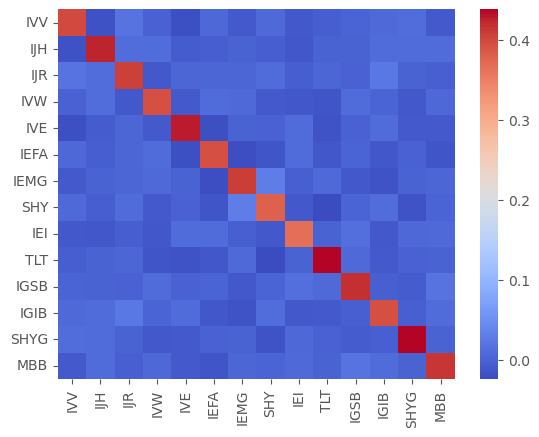

In [62]:
import seaborn as sns
sns.heatmap(shrunk_cov*100, cmap='coolwarm')

## Asset returns

We will only model investments held for one period. The initial prices are $p_i > 0$. The end of period prices are $p_i^+ >0$. The asset (fractional) returns are $r_i = (p_i^+-p_i)/p_i$. The porfolio (fractional) return is $R = r^Tw$.

A common model is that $r$ is a random variable with mean ${\bf E}r = \mu$ and covariance ${\bf E{(r-\mu)(r-\mu)^T}} = \Sigma$.
It follows that $R$ is a random variable with ${\bf E}R = \mu^T w$ and ${\bf var}(R) = w^T\Sigma w$.
${\bf E}R$ is the (mean) *return* of the portfolio. ${\bf var}(R)$ is the *risk* of the portfolio.
(Risk is also sometimes given as ${\bf std}(R) = \sqrt{{\bf var}(R)}$.)

Portfolio optimization has two competing objectives: high return and low risk.
## Classical (Markowitz) portfolio optimization

Classical (Markowitz) portfolio optimization solves the optimization problem

$$
\begin{array}{ll} & \mu^T w - \gamma w^T\Sigma w\\
s.t. & {\bf 1}^T w = 1, \quad w \in {\cal W},
\end{array}
$$

where $w \in {\bf R}^n$ is the optimization variable, $\cal W$ is a set of allowed portfolios (e.g., ${\cal W} = {\bf R}_+^n$ for a long only portfolio), and $\gamma >0$ is the *risk aversion parameter*.

The objective $\mu^Tw - \gamma w^T\Sigma w$ is the *risk-adjusted return*. Varying $\gamma$ gives the optimal *risk-return trade-off*.
We can get the same risk-return trade-off by fixing return and minimizing risk.

## Markowitz portfolio optimization with Constraints

The above optimization problem is updated with constraints

$$
\begin{array}{ll} & \mu^T w - \gamma w^T\Sigma w\\
s.t. & {\bf 1}^T w = 1, \\
& l \le {\bf A} w \le u,\\
& w_{min} \le w \le w_{max},\\
& \quad w \in {\cal W},\\
\end{array}
$$


In [63]:
from optimizer import CVXOptimisation
gamma_values = np.logspace(1, 3, 50)
gamma_values = gamma_values[::-1]
A = np.array([[1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.]])
ub = np.array([[0.65]])
lb = np.array([[0.55]])
ret_vals = []
risk_vals = []

for risk_aversion in gamma_values:
    o = CVXOptimisation()
    o.set_objective(expected_returns, shrunk_cov, risk_aversion)
    o.set_constraints(
    {
        'min_weight': 0.05,
        'max_weight': 0.15,
        'sum_weights': 1.0,
        'factor_constraint' :[A, lb, ub]
    })
    o.solve()
    if o._problem.status != 'optimal':
        print('Optimization problem not solved')
    else:
        weights = o.get_weights()
        ret = (expected_returns.T @ weights)*100
        ret_vals.append(ret.iloc[0, 0])
        risk = np.sqrt(weights.T @ cov @ weights)*100
        risk_vals.append(risk[0, 0])

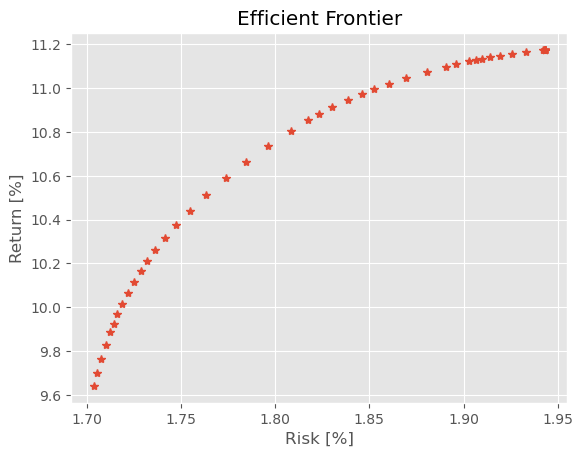

In [68]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
fig, ax = plt.subplots(1,1)
ax.plot(risk_vals, ret_vals, '*')
ax.set_xlabel('Risk [%]')
ax.set_ylabel('Return [%]')
ax.title.set_text('Efficient Frontier')
plt.show()